# Timeseries with recurrent neural networks

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')


# 1.0 Sunspots
## 1.1 Loading data

In [2]:
import sys
sys.path.insert(0, "../..")
from src.data import make_dataset
from pathlib import Path
import gin

datadir = Path("../../data/raw")
data = make_dataset.get_sunspots(datadir=datadir)
data.head()

2022-05-13 13:38:05.552 | INFO     | src.data.make_dataset:get_sunspots:72 - Found ../../data/raw/sunspots.csv, load from disk


,year,MonthlyMean
0,1749.042,96.7
1,1749.123,104.3
2,1749.204,116.7
3,1749.288,92.8
4,1749.371,141.7


This is data on sunspots, since 1749, in a pandas dataframe. Let us cast this to a `float32` Torch Tensor.

We first need to get the numpy data out of the pandas, and the cast that to a float32 Tensor.

In [3]:
import torch
series = data['MonthlyMean']
tensordata = torch.from_numpy(series.to_numpy()).type(torch.float32)
tensordata


tensor([ 96.7000, 104.3000, 116.7000,  ...,  59.7000,  78.5000,  84.1000])

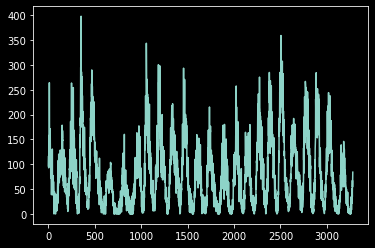

In [4]:
plt.plot(tensordata);

## 1.2 Train-test split
There seems to be some pattern. But also a lot of noise. We need to take this into account for our final model: it might be hard to get very high accuracy, because we dont have any additional features (could you think of possible relevant features?).

So let's make a train-test split, and normalize on the trainset. Note that we split on past-future! (Why is this important?)

In [5]:
# Train test split
split = 2500
train = tensordata[:split]

norm = max(train)
test = tensordata[split:]

train = train / norm
test = test/ norm

What would go wrong if you normalize on the max of the testset?

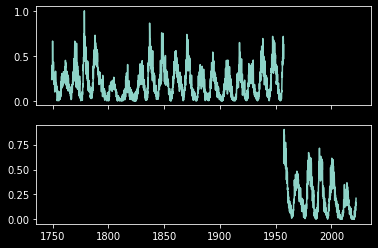

In [7]:
# reduce steps back to months, starting in 1749
idx0 = torch.arange(0, len(train)) / 12 + 1749
idx1 = torch.arange(0, len(test)) / 12 + idx0.max()
fig, axs = plt.subplots(2, sharex=True)
axs[0].plot(idx0, train)
axs[1].plot(idx1,test)

## 1.3 Windowing

Now, let's use our windowed datagenerator.

Regarding the windowsize, we will have to ask ourselves: what is a reasonable time, we will need to look into the past to be able to predict the future? If we make it too long, we will get irrelevant data (eg, does the amount of sunspots a hundred years still impact significantly the sunspots in 2020? If you think so, you should increase your window by a lot!)

In [8]:
from src.data import data_tools

window_size = 26 # this is just a wild guess. A bit over 2 years.
idx = data_tools.window(train, window_size)
trainset = train[idx]
idx = data_tools.window(test, window_size)
testset = test[idx]
trainset.shape, testset.shape

(torch.Size([2475, 26]), torch.Size([755, 26]))

Ok, that is looking good. We squeezed out 2475 training examples out of this long, single timeseries.

## 1.4 A custom dataset

Let's make the data 3D, just as our timeseries model will need to have it. We just have one feature, so that is just a dimension of 1.

In [9]:
from torch.utils.data import DataLoader
trainset = trainset[...,None]
testset = testset[..., None]

We can implement a Dataset in PyTorch. We can inherit the `Dataset` class, and if we implement a `__len__` and `__getitem__` function, we are good.

In [53]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, data, horizon):
        self.data = data
        self.size = len(data)
        self.horizon = horizon
    
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        # get a single item
        item = self.data[idx]
        # slice off the horizon
        x = item[:-self.horizon,:]
        y = item[-self.horizon:,:].squeeze(-1) # squeeze will remove dimension -1 if possible.
        return x, y

Let us test if this works as expected

In [54]:
dummydata = torch.randint(0, 10, (100, 10, 2))
dummydataset = CustomDataset(dummydata, horizon=2)
len(dummydataset)

100

In [57]:
x, y = dummydataset[0]
x.shape, y.shape # no squeeze because we have dimension 2 as the last dimension

(torch.Size([8, 2]), torch.Size([2, 2]))

Ok, now we apply this on the trainset.

In [58]:
trainset.shape

torch.Size([2475, 26, 1])

In [59]:
horizon = 3
traindataset = CustomDataset(trainset, horizon=horizon)
testdataset = CustomDataset(testset, horizon=horizon)

In [60]:
x, y = traindataset[1]
x.shape, y.shape # here we see the squeeze happening

(torch.Size([23, 1]), torch.Size([3]))

## 1.5 A Dataloader
This seems to work as well. Now we can give this to a Dataloader to batch and shuffle it for us.

In [61]:
trainloader = DataLoader(traindataset, batch_size=32, shuffle=True)
testloader = DataLoader(testdataset, batch_size=32, shuffle=True)

Can you make sense of all the output?
What is going on? Is that what you expected?

In [62]:
x, y = next(iter(trainloader))
x.shape, y.shape # here we see the squeeze in action

(torch.Size([32, 23, 1]), torch.Size([32, 3]))

What do you think these numbers are?

In [63]:
len(trainloader.dataset), len(trainloader)

(2475, 78)

# 2 Exploring baseline models
## 2.1 Naive models

The most basic prediction is a Naive model. 

- What is a naive prediction of the temperature for tomorrow? Well, the temperature of today.
- The stock market for tomorrow? Same as today.
- Bitcoin for march 16th of 2028? Same as march 15th 2028.

In general, this is a super simple model without any parameters but often much better than you would expect, because the temparature of today will be close to the temperature of tomorrow.

In general, you can say:

$$ f: x_{t} \rightarrow x_{t+1} $$

where $f$ is just the Identity function $f(x) = x$

This gives rise to the MASE, the Mean Absolute Scaled Error: It is the mean absolute error of the forecast values 
$\frac{1}{J}\sum_j|e_j|$, but scaled by the mean absolute error of the in-sample one-step naive forecast $|Y_t-Y_{t-1}|$:

$$ MASE = \frac{\frac{1}{J}\sum_j|e_j|}{
\frac{1}{T-1} \sum_{t=2}^{T}|Y_t-Y_{t-1}|} $$

In other words, the MASE compares your MAE to the MAE of the naive model. 

E.g. if the error of your model is 1, and the error of the naive model is 10, your MASE is 0.1, meaning you are much better than the naive prediction.

MASE values above 1 are bad, below (ideally close to 0) is good.
We will implement this ourselves. First the naive prediction:

In [64]:
from typing import Tuple
Tensor = torch.Tensor

def naivepredict(x: Tensor, horizon: int) -> Tuple[Tensor, Tensor]:
    assert horizon > 0
    yhat = x[...,-horizon:, :].squeeze(-1)
    return yhat

In [65]:
yhat = naivepredict(x, horizon)
yhat.shape

torch.Size([32, 3])

With the naive prediction, we can calculate the MAE

In [66]:
def mae(y: Tensor, yhat: Tensor) -> Tensor:
    return torch.mean(torch.abs(y-yhat))

In [67]:
mae(y, yhat)

tensor(0.0568)

Now, we want to calculate the naive MAE for every batch, to get the average, expected MAE for the naive prediction

In [69]:
def naivenorm(dataloader: DataLoader, horizon: int):
    elist = []
    for x, y in dataloader:
        yhat = naivepredict(x, horizon)
        e = mae(y, yhat)
        elist.append(e)
    return torch.mean(torch.tensor(elist))
naivenorm(trainloader, 1)

tensor(0.0560)

This means, a MAE close to this number is not impressive at all. We need to get below this if we want to go beyond the naive prediction.
We can wrap everything in a class, so it is neatly organized.

In [71]:
Tensor = torch.Tensor
class MASE:
    def __init__(self, dataloader: DataLoader, horizon: int):
        self.scale = self.naivenorm(dataloader, horizon)
    
    def __repr__(self) -> str:
        # __repr__ is what is returned if you print the class to the screen 
        return f"MASE(scale={self.scale:.3f})"

    def naivenorm(self, dataloader: DataLoader, horizon: int):
        elist = []
        for x, y in dataloader:
            yhat = self.naivepredict(x, horizon)
            e = self.mae(y, yhat)
            elist.append(e)
        return torch.mean(torch.tensor(elist))
    
    def naivepredict(self, x: Tensor, horizon: int) -> Tuple[Tensor, Tensor]:
        assert horizon > 0
        yhat = x[...,-horizon:, :].squeeze(-1)
        return yhat

    def mae(self, y: Tensor, yhat: Tensor) -> Tensor:
        return torch.mean(torch.abs(y-yhat))
    
    def __call__(self, y: Tensor, yhat: Tensor) -> Tensor:
        # __call__ lets us call the class as a function
        return self.mae(y, yhat) / self.scale

In [72]:
mase = MASE(trainloader, horizon)
mase # __repr__ in action

MASE(scale=0.062)

In [73]:
mase(y, yhat) # __call__ in action

tensor(0.9194)

## 2.2 Linear model
Ok, we have everything in place. Let's start with a slightly more advanced model than a naive one.

We start with a linear baselinemodel, of just a single `Linear` layer with one unit. This is equal to a linear model.

Check out the sourcecode (tip: VS code let's you do so easily by pressing F12, or by right-clicking the mouse on a function and selecting `Go to Definition`)

In [75]:
from src.models import rnn_models, metrics
observations = window_size - horizon
model = rnn_models.BaseModel(observations=observations, horizon=horizon)
x, y = next(iter(trainloader))
x.shape, y.shape

(torch.Size([32, 23, 1]), torch.Size([32, 3]))

Let's have a look at our random model

In [76]:
yhat = model(x)
yhat.shape

torch.Size([32, 3])

In [78]:
mase = metrics.MASE(trainloader, horizon)
mase(y, yhat)

tensor(6.1203, grad_fn=<DivBackward0>)

Oh boy! Untrained, this is actually much much worse than a naive model... Let's start training...

First, we add a regular MAE too.

In [79]:
mae = metrics.MAE()
mae(yhat, y)

tensor(0.3786, grad_fn=<MeanBackward0>)

In [80]:
from datetime import datetime
from pathlib import Path
gin.parse_config_file("model.gin")

timestamp = datetime.now().strftime("%Y%m%d-%H%M")
log_dir = Path("../../models/rnn/" + timestamp)
if not log_dir.exists():
    log_dir.mkdir(parents=True)

observations = window_size - horizon
model = rnn_models.BaseModel(observations=observations, horizon=horizon)

model = rnn_models.trainloop(
    model=model,
    metrics=[mase, mae],
    train_dataloader=trainloader,
    test_dataloader=testloader,
    log_dir=log_dir,
)


2022-05-13 14:21:22.825 | INFO     | src.data.data_tools:clean_dir:167 - Clean out ../../models/rnn/20220513-1421
100%|██████████| 200/200 [00:12<00:00, 16.08it/s]


If you have a look at Tensorboard, you can see the model is learning!

In [81]:
x, y = next(iter(testloader))
yhat = model(x)
mae(y, yhat), mase(y, yhat)

(tensor(0.0485, grad_fn=<MeanBackward0>),
 tensor(0.7840, grad_fn=<DivBackward0>))

And, yes, the MASE dropped below 1! This is a good start.

Let's visualize this.

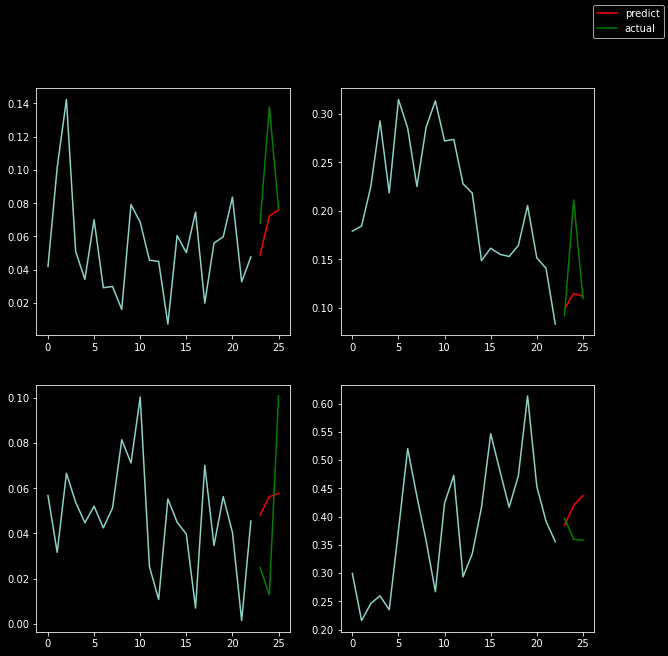

In [82]:
k = 4
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
axs = ax.ravel()

timesteps = x.shape[1]
idx0 = [*range(timesteps)]
idx1 = [(i + timesteps) for i in range(horizon)]
for i in range(k):
    axs[i].plot(idx0, x[i])
    axs[i].plot(idx1, yhat[i].detach(), color="red", label="predict")
    axs[i].plot(idx1, y[i], color="green", label="actual")
handles, labels = axs[i].get_legend_handles_labels()
fig.legend(handles, labels)

Well, it is not perfect, obviously. But it does seem to capture the trend.

## 2.3 Simple RNN

Let's invoke the basic RNN without gates.

Input size is 1, because we have 1 feature. We follow [the batch_first convention](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html). Hidden size is the inner dimension of the RNN, and thus the dimensionality of the output.

What would happen if we feed this data with dimensions `(batch, sequence_length)`?

In [86]:
x = torch.randn((32, 25))
rnn = torch.nn.RNN(input_size=1, hidden_size=1, batch_first=True)
try:
    yhat = rnn(x)
except RuntimeError as e:
    print(e)

input must have 3 dimensions, got 2


Note how it expects 3 dimensions : `(batch, sequence_length, features)`, even though we have just one feature.

In [87]:
x, y = next(iter(trainloader))
x.shape, y.shape

(torch.Size([32, 23, 1]), torch.Size([32, 3]))

In [88]:
out, hidden = rnn(x)
out.shape, hidden.shape

(torch.Size([32, 23, 1]), torch.Size([1, 32, 1]))

This works as expected. Let's increase the hidden dimension (why would you do that?)

In [89]:
rnn = torch.nn.RNN(input_size=1, hidden_size=10, batch_first=True)
out, hidden = rnn(x)
out.shape, hidden.shape

(torch.Size([32, 23, 10]), torch.Size([1, 32, 10]))

And let's add multiple stacked layers of RNN (can you visualize how this would work?)

In [90]:
rnn = torch.nn.RNN(
    input_size=1,
    hidden_size=10,
    num_layers=3,
    batch_first=True)
out, hidden = rnn(x)
out.shape, hidden.shape

(torch.Size([32, 23, 10]), torch.Size([3, 32, 10]))

To get the output of the last timestep, we need to throw away the rest.

In [91]:
out = out[:,-1,:]
out.shape

torch.Size([32, 10])

So, let's wrap this up in a model. Study the implementation in `rnn_models.BaseRNN`.

Do you understand what the linear layer does? What would happen if you remove it?

In [92]:
from src.models import metrics, rnn_models

mase = metrics.MASE(trainloader, horizon)
mae = metrics.MAE()

In [93]:
gin.parse_config_file("model.gin")
timestamp = datetime.now().strftime("%Y%m%d-%H%M")
log_dir = Path("../../models/rnn/" + timestamp)
if not log_dir.exists():
    log_dir.mkdir(parents=True)

observations = window_size - horizon
model = rnn_models.BaseRNN(horizon=horizon)

model = rnn_models.trainloop(
    model=model,
    metrics=[mase, mae],
    train_dataloader=trainloader,
    test_dataloader=testloader,
    log_dir=log_dir,
)

2022-05-13 14:33:47.779 | INFO     | src.data.data_tools:clean_dir:167 - Clean out ../../models/rnn/20220513-1433
100%|██████████| 200/200 [00:38<00:00,  5.21it/s]


Does this improve over the linear model?
By how much? Is there a difference between loss and MASE? 

What does it mean?

Can you improve the model by tweaking it?